In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz, kelvin,angstrom
import h5py
from synthesizer.load_data.load_camels import load_CAMELS_Astrid
from synthesizer.grid import Grid
from synthesizer.sed import Sed
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds
from synthesizer.emission_models import (
    IncidentEmission,
)

from synthesizer.conversions import lnu_to_absolute_mag, fnu_to_apparent_mag, fnu_to_lnu

In [2]:
# define functions

# Absolute magnitude is defined to be the apparent magnitude an object would have if it were located at a distance of 10 parsecs.
# In astronomy, absolute magnitude (M) is a measure of the luminosity of a celestial object on an inverse logarithmic astronomical magnitude scale.
# only need this apparent mag function if using Mats code for calculating UVLF.
def apparent_magnitude_from_absolute(redshift, absolute_magnitude):
    # Get the luminosity distance for the given redshift
    # Distnaces are in parsecs
    d_L_pc = Planck18.luminosity_distance(redshift).to('pc').value
    
    # Calculate the apparent magnitude using the distance modulus formula
    apparent_mag = absolute_magnitude - 5 + (5 * np.log10(d_L_pc))
    
    return apparent_mag

# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_df(ab_mag, volume, massBinLimits):

# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors

        return phi, phi_sigma, hist


In [3]:
# get grid for all galaxies
# gives grid of metalicity and age which is used to map on our camels galaxies
grid_name = "bc03_chabrier03-0.1,100.hdf5"
#grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5" # try old grid, LF looks weird?!
grid_dir = "/home/jovyan/"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

In [4]:
# get gals
output_dir = '/home/jovyan/camels/CV_set/CV_outputs/LFs/Astrid/'
directories = [f'CV_{i}' for i in range(27, 28)]
skipped_directories = []
directories

['CV_27']

In [5]:
# get filters:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400*angstrom, lam_max=1600*angstrom, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)


In [6]:
# set incident emission model
incident = IncidentEmission(grid)
# set little h value
little_h =  0.6711


In [7]:
for CV_X in directories:
    try:
        # create an empty dictionary to store your data - reset in loop
        data_dict = {}
        
        # Get grid for all galaxies
        _dir = '/home/jovyan/Data/Sims/Astrid/CV/' + CV_X
        gals_074 = load_CAMELS_Astrid(
            _dir,
            snap_name='snapshot_074.hdf5', 
            group_name='groups_074.hdf5',
        )
        
        cat_074 = dir_+'/groups_074.hdf5'
        
        # open file
        f = h5py.File(cat_074, 'r')
        
        # read different attributes of the header
        boxSize_074 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
        redshift_074 = f['Header'].attrs[u'Redshift']

        # Filter galaxies to only include those with 100 or more star particles
        ## NEED TO ADD FILTER TO GET RID OF ANY GALAXIES WITH LESS THAN 100 star Particles!! This is the resolution limit!!
        # Chris: when you load your galaxies in could you do a filter for those with at least 100 star particles? that's the resolution limit
        
        # Filter galaxies to only include those with 100 or more star particles
        gals_074 = [gal for gal in gals_074 if gal.stars.nstars >= 100]
        gals_074 = [gal for gal in gals_074 if gal.gas.nparticles >= 100]
        #gals_074 = [gal for gal in gals_074 if len(gal.stars.ages) >= 100]  # this shouldnt be here?! donesnt make sense

        spec_list = []
        # Lets work with z=0 so gals_025
        for i in gals_074:
            gal = i
            # get_spectra_incident An Sed object containing the stellar spectra
            spec = gal.stars.get_spectra(incident)
            spec.get_fnu0()
            spec_list.append(spec)

        # combine our seds
        seds = combine_list_of_seds(spec_list)
        seds.lnu  # get luminosity

        # get rest frame photometry for our filters
        phot = seds.get_photo_lnu(combined_filters, verbose=True) 
        
        # now using the filters which got the rest frame lum, get the abs magnitude in those filters
        #abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]
        # just want top hat filter for now
        abs_mags = [lnu_to_absolute_mag(phot[f]) for f in combined_filters.filters]

        # next steps, get luminosity function for these magnitudes
        # co-moving volume: BoxSize_025 and redshift:
        little_h =  0.6711
        Vphys = (boxSize_074/little_h )**3
        Vcom = Vphys * ((1+redshift_074)**3)
        
         # Define the bin edges for AB magnitudes
        # Here, let's define bins from -25 to -17 in steps of 0.5 magnitude
        massBinLimits = np.arange(-22, -16, 0.5)

        # calc LF
        phi, phi_sigma, hist = calc_df(abs_mags, Vcom, massBinLimits)
        
        # Define output file path
        output_file = f"{output_dir}{CV_X}.txt"

        # Write the data to the text file
        with open(output_file, 'w') as txtfile:
            # Write phi values
            txtfile.write("phi\n")
            for value in phi:
                txtfile.write(f"{value}\n")

            # Write phi_sigma values
            txtfile.write("phi_sigma\n")
            for value in phi_sigma:
                txtfile.write(f"{value}\n")

            # Write hist values
            txtfile.write("hist\n")
            for value in hist:
                txtfile.write(f"{value}\n")

            # Write massBinLimits values
            txtfile.write("massBinLimits\n")
            for value in massBinLimits:
                txtfile.write(f"{value}\n")

        print(f'Written out: {output_file}')

    except Exception as e:
        print(f"Error processing {CV_X}: {e}")
        skipped_directories.append(CV_X)

# Print skipped directories at the end
if skipped_directories:
    print("Skipped directories:", skipped_directories)

Error processing CV_27: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/jovyan/Data/Sims/Astrid/CV/CV_27/snapshot_074.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Skipped directories: ['CV_27']


In [8]:
import os
import pandas as pd

# Define the directory containing the LH_X files
directory = "/home/jovyan/camels/CV_set/CV_outputs/LFs/Astrid/"

# Get all files in the directory
files = os.listdir(directory)

# Filter out files that start with "LH_" and end with ".txt"
CV_X_files = [file for file in files if file.startswith("CV_") and file.endswith(".txt")]

# Initialize lists to store data
phia = []
phi_sigmaa = []
binsa = []
CV_X_values = []

# Iterate over LH_X files
for CV_X_file in CV_X_files:
    # Define the file path
    file_path = os.path.join(directory, CV_X_file)
    
    # Extract LH_X value from the file name (remove the ".txt" extension)
    CV_X = CV_X_file[:-4]
    
    # Initialize an empty dictionary to store variable names and their values
    variable_data = {}

    # Open the text file for reading
    with open(file_path, 'r') as file:
        # Initialize variables to store the current variable name and its values
        current_variable_name = None
        current_variable_values = []

        # Iterate over each line in the file
        for line in file:
            # Remove leading and trailing whitespace from the line
            line = line.strip()

            # Check if the line is empty
            if not line:
                continue

            # Check if the line is a variable name
            if line in ['phi', 'phi_sigma', 'hist', 'massBinLimits']:
                # If it's a new variable name, update the current variable name and reset the values list
                if current_variable_name is not None:
                    variable_data[current_variable_name] = current_variable_values
                    current_variable_values = []

                current_variable_name = line
            else:
                # If it's not a variable name, convert the value to float and append it to the values list
                current_variable_values.append(float(line))

        # Add the last variable data to the dictionary
        if current_variable_name is not None:
            variable_data[current_variable_name] = current_variable_values
        
        # Extract specific variables
        phi = variable_data.get('phi')
        phi_sigma = variable_data.get('phi_sigma')
        bins = variable_data.get('massBinLimits')

        phia.append(phi)
        phi_sigmaa.append(phi_sigma)
        binsa.append(bins)
        CV_X_values.append(CV_X)

# Create a DataFrame from the lists
df = pd.DataFrame({'CV_X': CV_X_values, 'phi': phia, 'phi_sigma': phi_sigmaa, 'bins': binsa})

# Display the DataFrame
df


,CV_X,phi,phi_sigma,bins
0,CV_0,"[3.669797748803462e-05, 3.669797748803462e-05,...","[2.1187587181431613e-05, 2.1187587181431613e-0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
1,CV_1,"[3.669797748803462e-05, 9.786127330142564e-05,...","[2.1187587181431613e-05, 3.459918498349406e-05...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
2,CV_10,"[3.669797748803462e-05, 0.00014679190995213847...","[2.1187587181431613e-05, 4.2375174362863225e-0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
3,CV_11,"[0.0, 0.00014679190995213847, 0.00014679190995...","[0.0, 4.2375174362863225e-05, 4.23751743628632...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
4,CV_12,"[1.2232659162678205e-05, 3.669797748803462e-05...","[1.2232659162678205e-05, 2.1187587181431613e-0...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
5,CV_13,"[4.893063665071282e-05, 4.893063665071282e-05,...","[2.446531832535641e-05, 2.446531832535641e-05,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
6,CV_14,"[8.562861413874744e-05, 2.446531832535641e-05,...","[3.236457401746214e-05, 1.729959249174703e-05,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
7,CV_15,"[2.446531832535641e-05, 4.893063665071282e-05,...","[1.729959249174703e-05, 2.446531832535641e-05,...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
8,CV_16,"[0.0, 7.339595497606924e-05, 0.000146791909952...","[0.0, 2.9963773145942922e-05, 4.23751743628632...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."
9,CV_17,"[0.0, 2.446531832535641e-05, 6.116329581339103...","[0.0, 1.729959249174703e-05, 2.735305743333412...","[-22.0, -21.5, -21.0, -20.5, -20.0, -19.5, -19..."


In [9]:
# Generate the list of expected filenames
expected_files = [f'CV_{i}' for i in range(27)]

# Extract the filenames that are actually present in the DataFrame
present_files = df['CV_X'].tolist()

# Find the missing filenames
missing_files = set(expected_files) - set(present_files)

# If you want to print the missing files
print("Missing files:")
for file in sorted(missing_files):
    print(file)

Missing files:


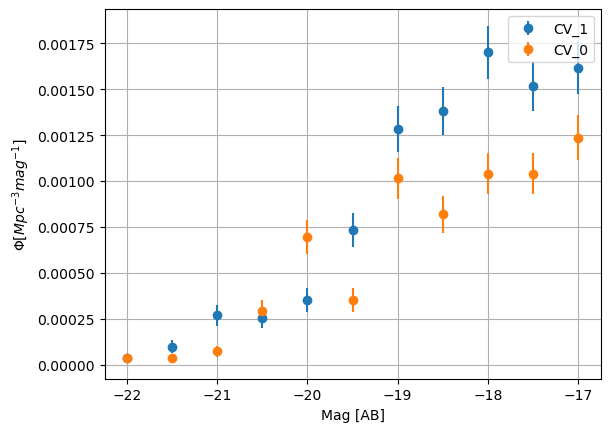

In [10]:
massBinLimits = np.arange(-22, -16, 0.5)

# Assuming df is your DataFrame containing the data
# Filter for CV_X == 103
specific_row = df[df['CV_X'] == 'CV_1']
specific_row2 = df[df['CV_X'] == 'CV_0']

# Check if the specific row is found
if not specific_row.empty:
    row = specific_row.iloc[0]
    row2 = specific_row2.iloc[0]
    plt.errorbar(massBinLimits[:-1], row['phi'], yerr=row['phi_sigma'], fmt='o', label=f'{row["CV_X"]}')
    plt.errorbar(massBinLimits[:-1], row2['phi'], yerr=row2['phi_sigma'], fmt='o', label=f'{row2["CV_X"]}')
    #plt.plot(arn_x, arn_y,color='black', label='Arnouts et al 2005')

    # Set x and y limits
    #plt.xlim(-22.5, -17.7)
    #plt.ylim(-7, -1)
    plt.xlabel('Mag [AB]')
    plt.ylabel('$\Phi [Mpc^{-3} mag^{-1}]$')
    #plt.yscale('log')
    plt.legend()  # Add legend

    #plt.title('Luminosity Function z=0.465')
    plt.grid(True)

    # Set the x-axis and y-axis limits
    #plt.xlim(-22, -17)  # Replace xmin and xmax with your desired limits for the x-axis
    #plt.ylim(1e-5, 0)  
    plt.show()
else:
    print("No data found for CV_X == 103")


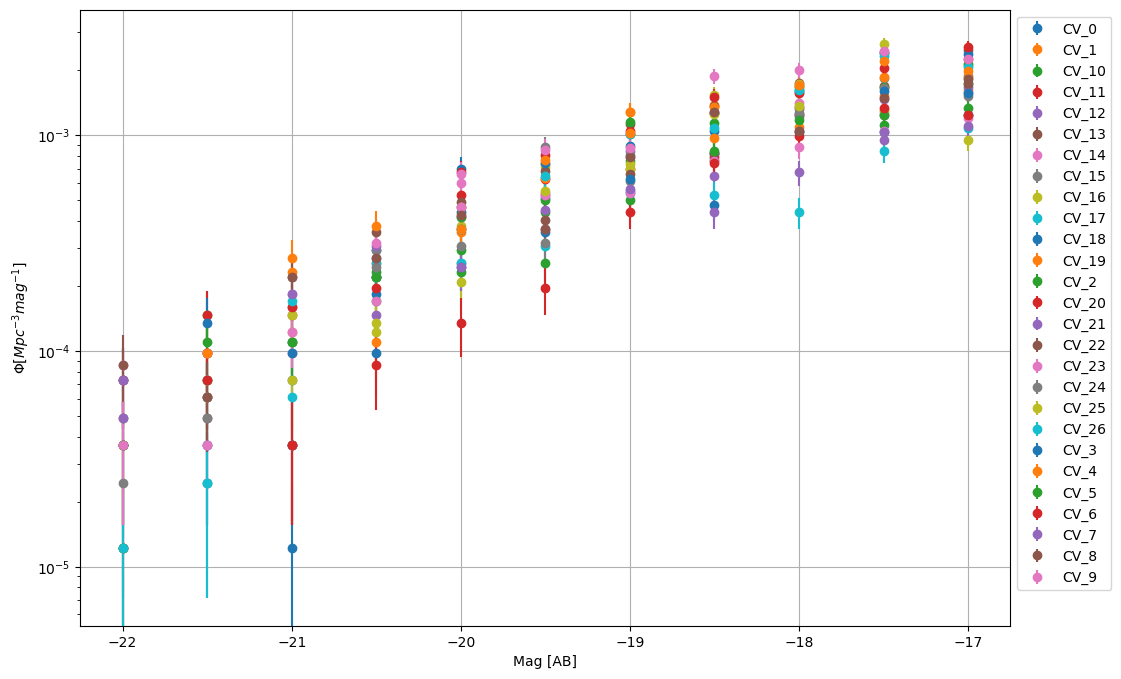

In [11]:
# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    phi = row['phi']
    phi_sigma = row['phi_sigma']

    # Plot each row's data with error bars
    plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', label=f'{row["CV_X"]}')

# Set plot labels and scale
plt.xlabel('Mag [AB]')
plt.ylabel('$\Phi [Mpc^{-3} mag^{-1}]$')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Change (1, 1) as needed for positioning

#plt.title('Luminosity Function z=0.465')
plt.grid(True)

# Set the x-axis and y-axis limits
#plt.xlim(-22, -16)  # Replace xmin and xmax with your desired limits for the x-axis
#plt.ylim(1e-5, None)  # Set the lower limit for the y-axis

# Show the plot
plt.show()


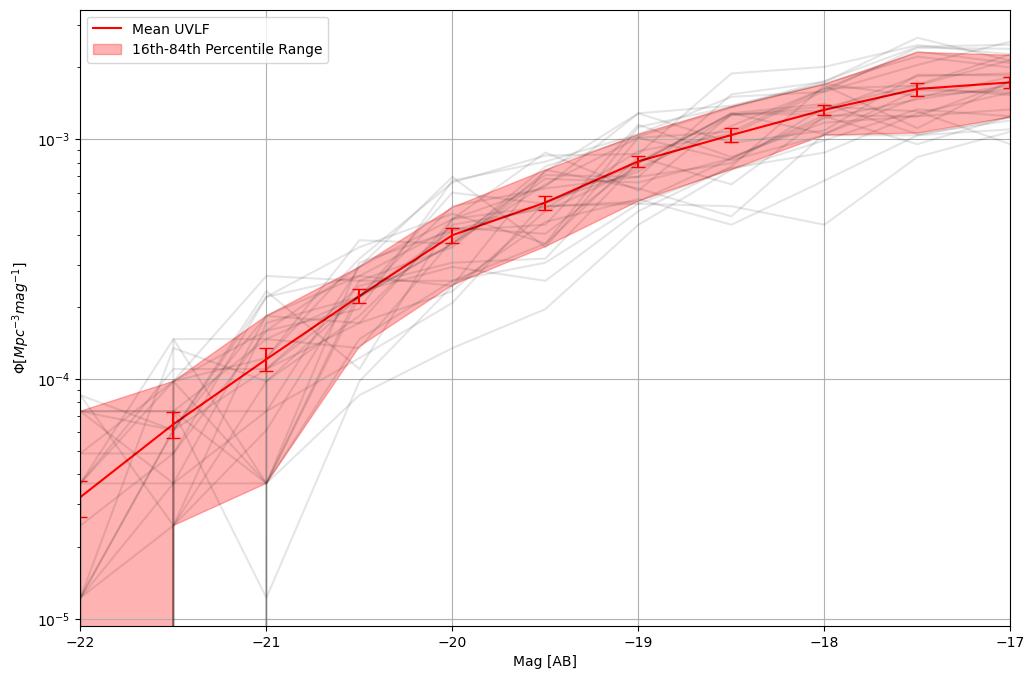

In [12]:
# Converts the lists in your DataFrame to NumPy arrays for efficient calculation.
#Calculates the mean UVLF across all simulations.
#Computes the 16th and 84th percentiles to show the range of variation due to cosmic variance.
#Plots the mean UVLF as a blue line.
#Shows the 16th-84th percentile range as a shaded blue area, representing the cosmic variance.
#Plots each individual simulation as a faint black line.
#Adds error bars to the mean line, showing the uncertainty in the mean itself.

#This visualization provides several insights:

#The overall trend of the UVLF (mean blue line).
#The range of variation due to cosmic variance (shaded area).
#How individual simulations (faint black lines) deviate from the mean.
#The uncertainty in the mean UVLF (error bars).

# Convert lists to numpy arrays for easier calculation
phi_arrays = np.array(df['phi'].tolist())
phi_sigma_arrays = np.array(df['phi_sigma'].tolist())

# Calculate mean and standard deviation across all simulations
mean_phi = np.mean(phi_arrays, axis=0)
std_phi = np.std(phi_arrays, axis=0)

# Calculate percentiles
lower_percentile = np.percentile(phi_arrays, 16, axis=0)
upper_percentile = np.percentile(phi_arrays, 84, axis=0)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot mean UVLF
plt.plot(massBinLimits[:-1], mean_phi, 'r-', label='Mean UVLF')

# Plot shaded region for 16th-84th percentile range
plt.fill_between(massBinLimits[:-1], lower_percentile, upper_percentile, 
                 alpha=0.3, color='r', label='16th-84th Percentile Range')

# Plot individual simulations with low opacity
for phi in phi_arrays:
    plt.plot(massBinLimits[:-1], phi, 'k-', alpha=0.1)

# Set plot labels and scale
plt.xlabel('Mag [AB]')
plt.ylabel('$\Phi [Mpc^{-3} mag^{-1}]$')
plt.yscale('log')
#plt.title('Mean UV Luminosity Function with Cosmic Variance (z=0.465)')
plt.legend()
plt.grid(True)

# Optional: Add error bars to mean line
plt.errorbar(massBinLimits[:-1], mean_phi, yerr=std_phi/np.sqrt(len(df)), 
             fmt='none', ecolor='r', capsize=5, label='Mean Uncertainty')

# Adjust plot limits if needed
plt.xlim(-22, -17)
# plt.ylim(1e-5, 1e-1)
plt.savefig("/home/jovyan/camels/CV_set/CV_outputs/plots/Astrid/UVLF_Mean_CV_Astrid.png", dpi=300, bbox_inches='tight')


plt.show()

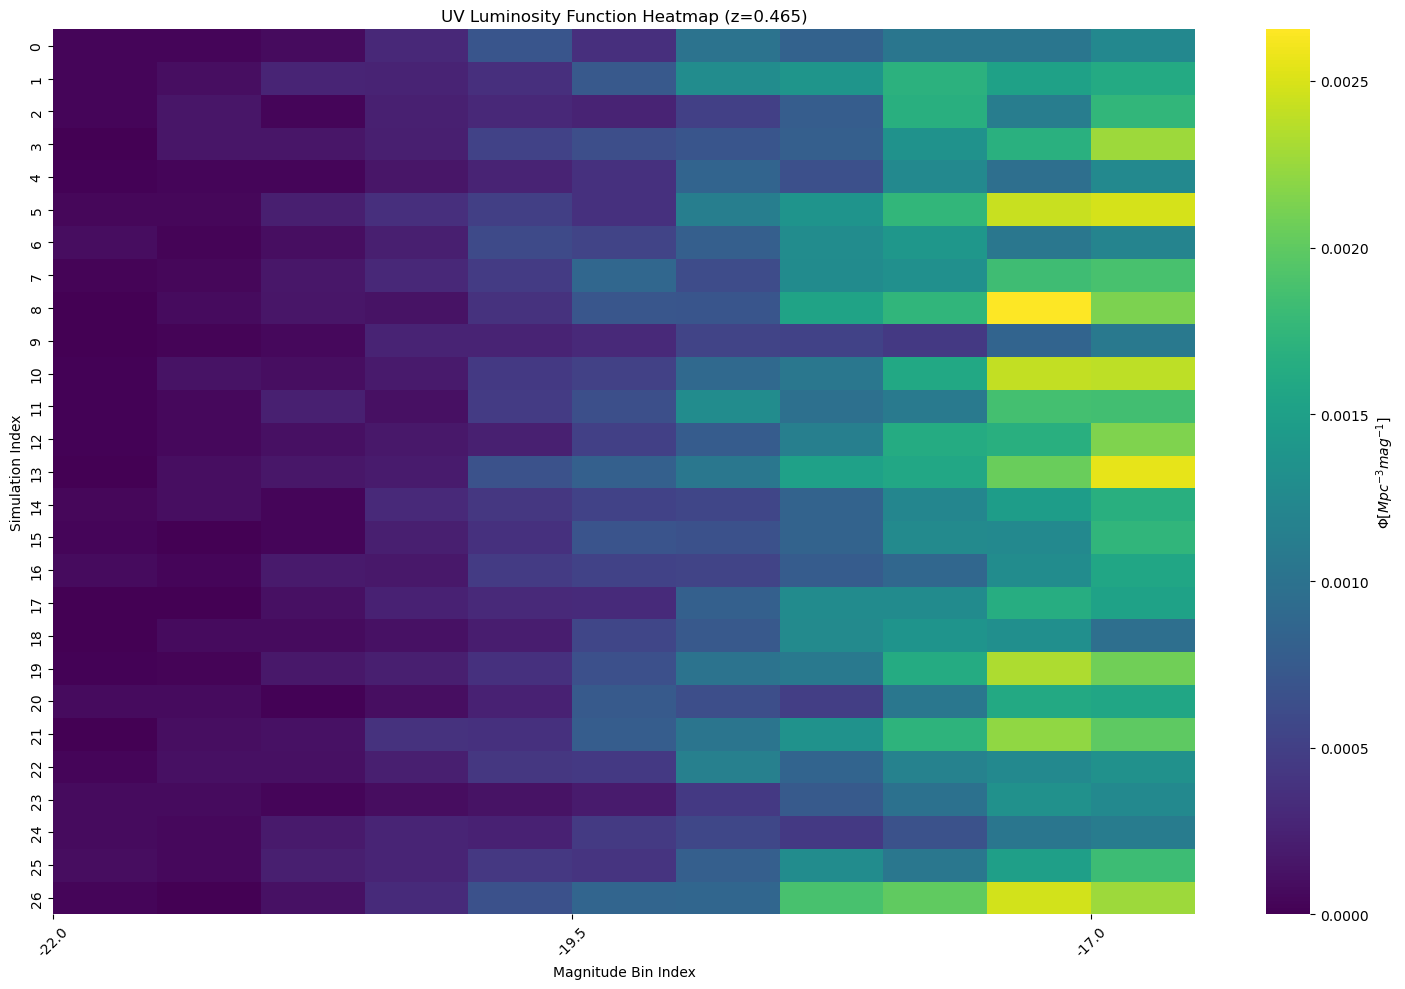

/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


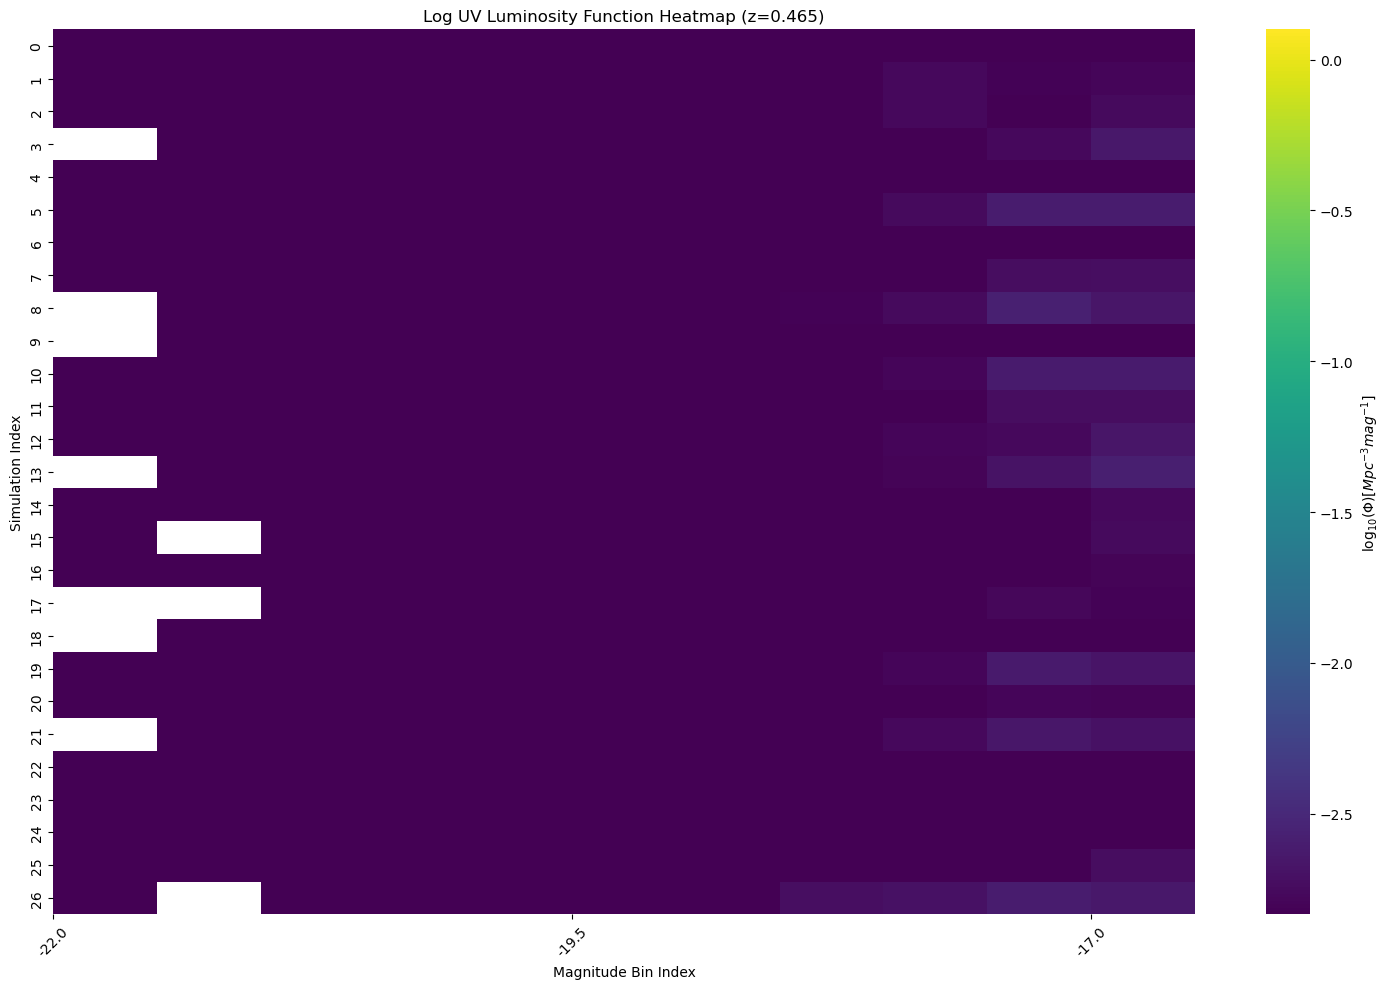

<Figure size 640x480 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming df is your DataFrame with all 27 simulations
# and massBinLimits is already defined

# Create a new DataFrame for the heatmap
heatmap_data = pd.DataFrame(df['phi'].tolist(), index=df.index)

# Create the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': '$\Phi [Mpc^{-3} mag^{-1}]$'})

# Set labels and title
plt.xlabel('Magnitude Bin Index')
plt.ylabel('Simulation Index')
plt.title('UV Luminosity Function Heatmap (z=0.465)')

# Optionally, add magnitude values to x-axis
mag_ticks = np.arange(0, len(massBinLimits)-1, 5)  # Adjust step size as needed
plt.xticks(mag_ticks, [f'{massBinLimits[i]:.1f}' for i in mag_ticks], rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Plot log of phi values for better contrast
plt.figure(figsize=(15, 10))
sns.heatmap(np.log10(heatmap_data), cmap='viridis', cbar_kws={'label': 'log$_{10}(\Phi) [Mpc^{-3} mag^{-1}]$'})

plt.xlabel('Magnitude Bin Index')
plt.ylabel('Simulation Index')
plt.title('Log UV Luminosity Function Heatmap (z=0.465)')

plt.xticks(mag_ticks, [f'{massBinLimits[i]:.1f}' for i in mag_ticks], rotation=45)

plt.tight_layout()
plt.show()

plt.savefig("/home/jovyan/camels/CV_set/CV_outputs/plots/Astrid/UVLF_HEATMAPS_CV_Astrid.png", dpi=300, bbox_inches='tight')


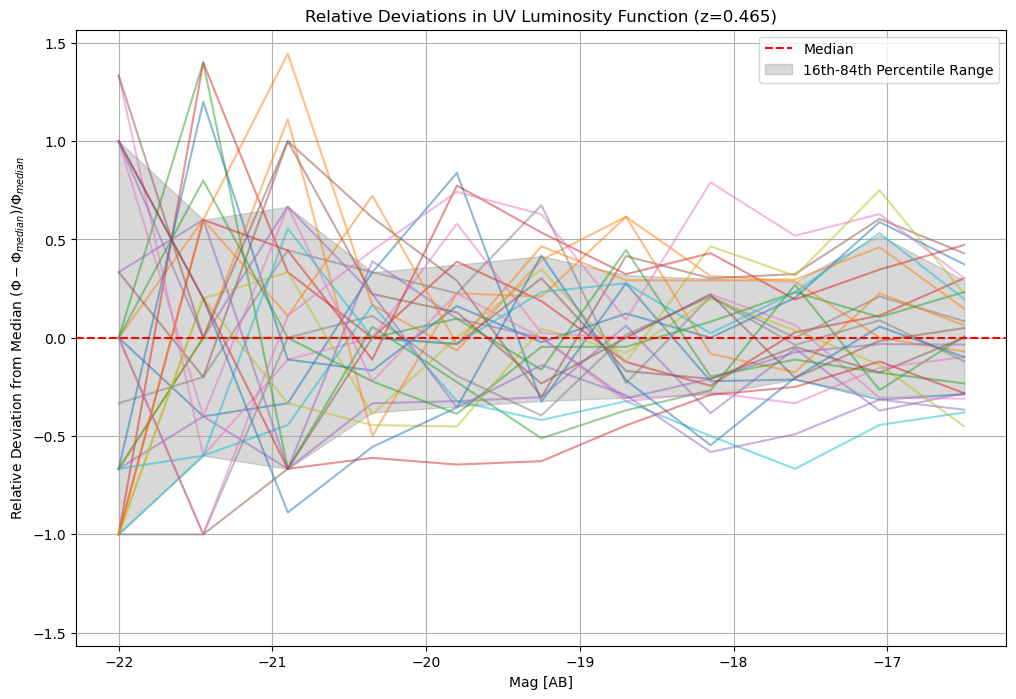

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming df is your DataFrame with all 27 simulations
num_mag_bins = len(df['phi'].iloc[0])

# Create magnitude bin centers (assuming equal width bins)
mag_bin_centers = np.linspace(massBinLimits[0], massBinLimits[-1], num_mag_bins)

# Stack all phi values
phi_values = np.vstack(df['phi'])

# Calculate median
median = np.median(phi_values, axis=0)

# Calculate relative deviations
relative_deviations = (phi_values - median) / median

# Create the plot
plt.figure(figsize=(12, 8))

# Plot relative deviations
for i in range(len(df)):
    plt.plot(mag_bin_centers, relative_deviations[i], alpha=0.5)

# Plot median line (which will be at y=0)
plt.axhline(y=0, color='r', linestyle='--', label='Median')

# Calculate and plot 16th and 84th percentiles of relative deviations
percentile_16 = np.percentile(relative_deviations, 16, axis=0)
percentile_84 = np.percentile(relative_deviations, 84, axis=0)
plt.fill_between(mag_bin_centers, percentile_16, percentile_84, 
                 alpha=0.3, color='gray', label='16th-84th Percentile Range')

# Set plot labels and scale
plt.xlabel('Mag [AB]')
plt.ylabel('Relative Deviation from Median $(\Phi - \Phi_{median}) / \Phi_{median}$')
plt.title('Relative Deviations in UV Luminosity Function (z=0.465)')
plt.legend()
plt.grid(True)

# Adjust y-axis to be symmetric around 0
y_max = max(abs(plt.ylim()[0]), abs(plt.ylim()[1]))
plt.ylim(-y_max, y_max)
plt.savefig("/home/jovyan/camels/CV_set/CV_outputs/plots/Astrid/RelativeDeviations_16th18thPercentile_CV_Astrid.png", dpi=300, bbox_inches='tight')

plt.show()

# Optional: Create a boxplot of relative deviations
plt.figure(figsize=(12, 8))
sns.boxplot(data=relative_deviations.T)
plt.xlabel('Magnitude Bin Index')
plt.ylabel('Relative Deviation from Median')
plt.title('Distribution of Relative Deviations Across Magnitude Bins')
plt.xticks(range(0, num_mag_bins, 2), [f'{mag_bin_centers[i]:.2f}' for i in range(0, num_mag_bins, 2)], rotation=45)
plt.show()
plt.savefig("/home/jovyan/camels/CV_set/CV_outputs/plots/Astrid/RelativeDeviations_BOXPLOT16th18thPercentile_CV_Astrid.png", dpi=300, bbox_inches='tight')
